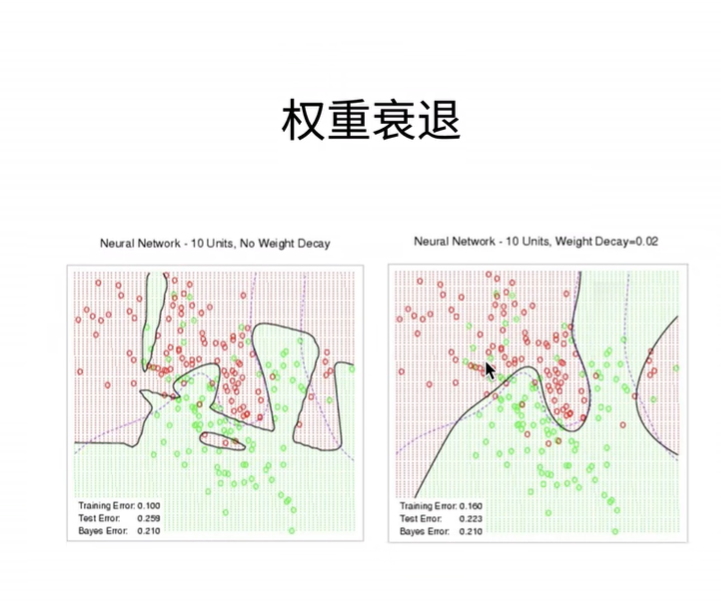

权重衰退是一种常见的处理过拟合的方法

数据简单 就要选择模型容量低的 若选择复杂模型 则会过拟合 并没有泛化性

权重衰退（Weight Decay），也称为L2正则化（L2 Regularization），是机器学习和深度学习中常用的一种正则化技术。它通过在损失函数中添加一个与模型权重相关的惩罚项，来防止模型过拟合。

作用
防止过拟合：通过惩罚较大的权重值，权重衰退可以防止模型在训练数据上表现得过于复杂，从而提高模型在测试数据上的表现。
简化模型：较小的权重值意味着模型更简单，更具泛化能力，能够更好地适应新的数据。
提高泛化能力：通过减少模型复杂度，权重衰退可以提高模型的泛化能力，使模型能够更好地处理未见过的数据。


权重衰退的基本概念

一些正则化模型的技术 对模型容量进行控制

我们可以通过调整拟合多项式的阶数来限制模型的容量。



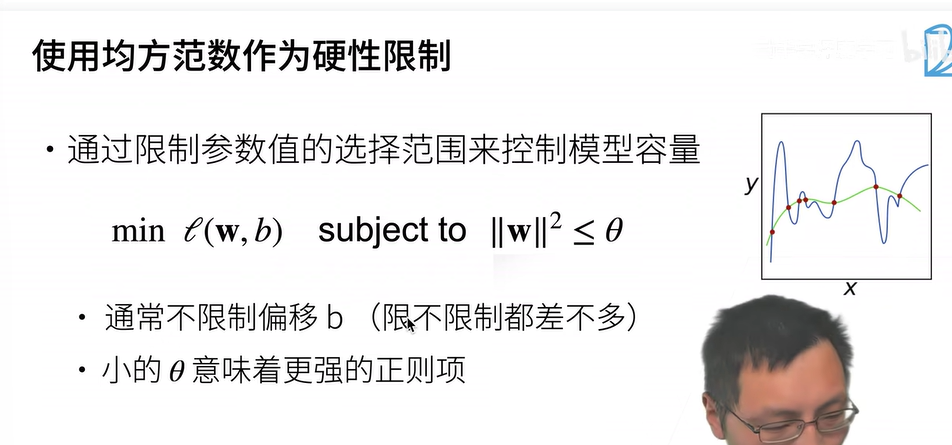

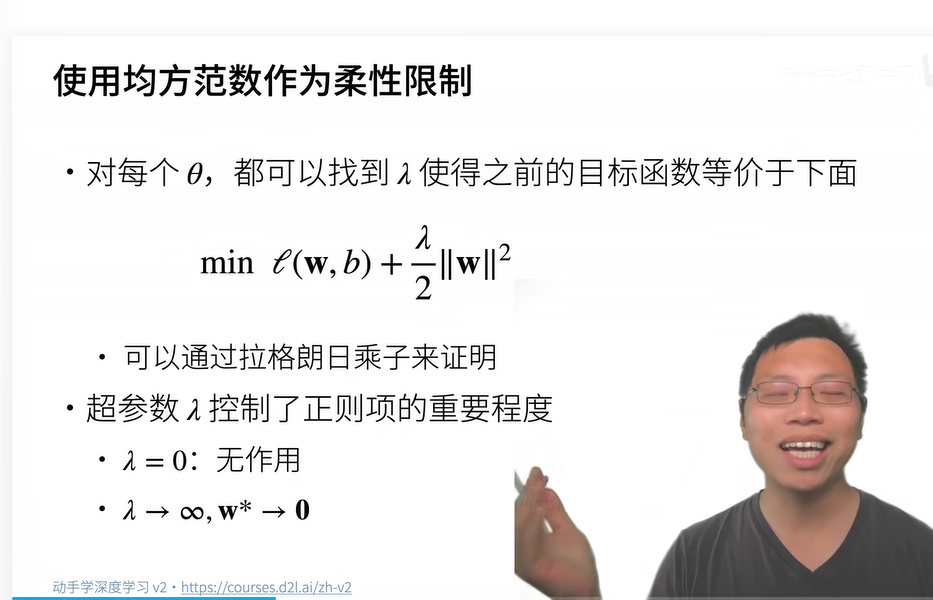

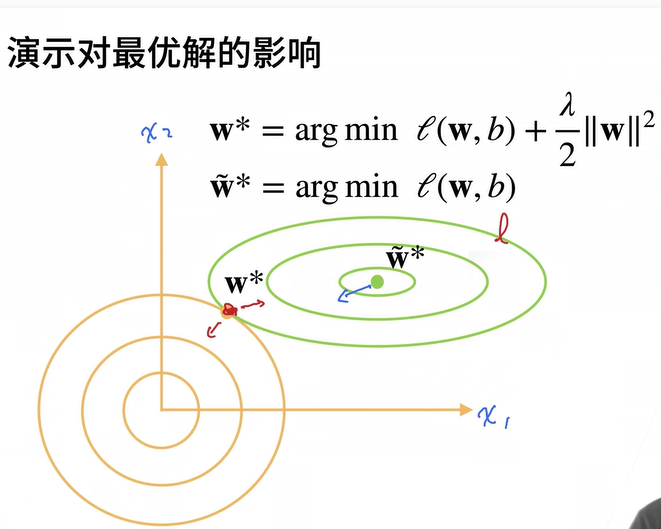

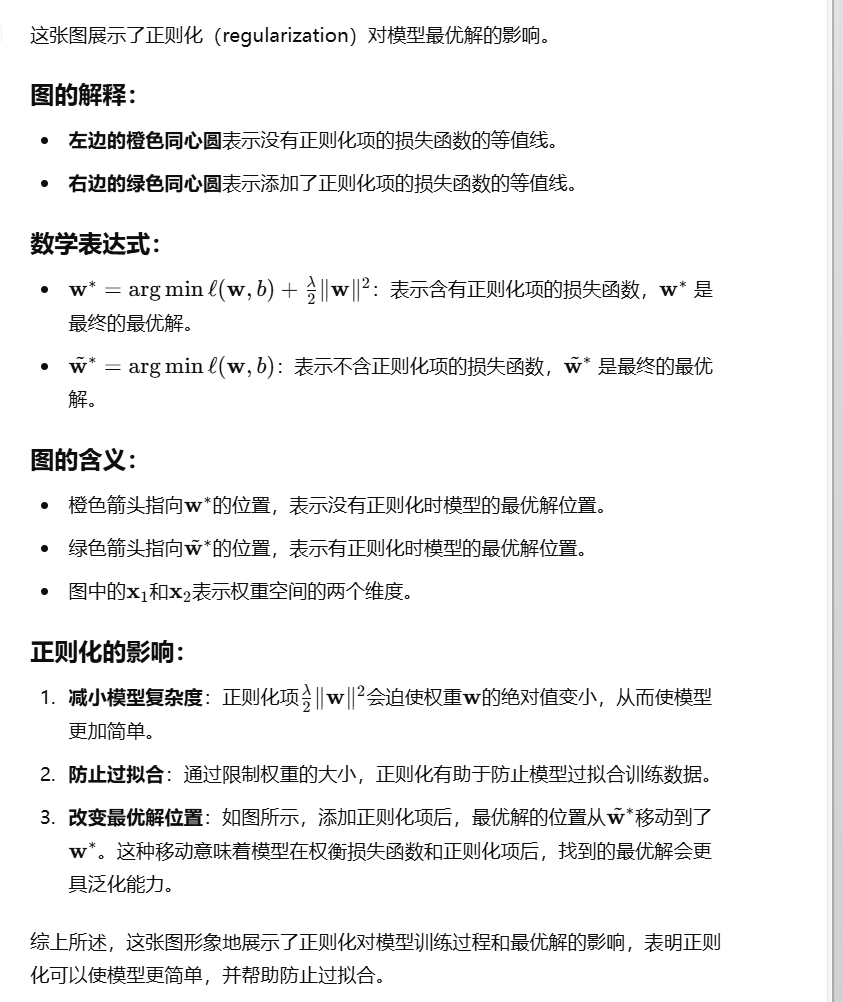

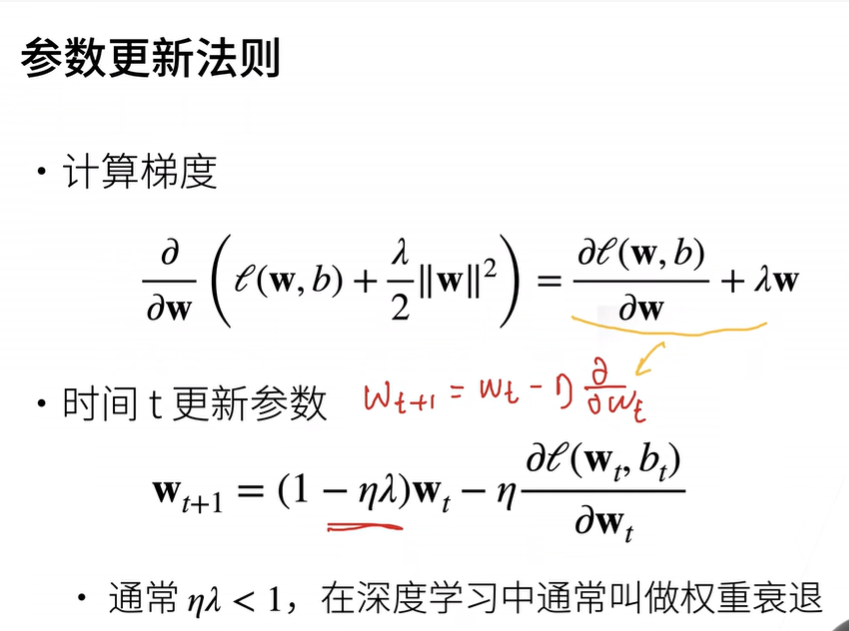

每一次更新权重时 使当前的权重放小

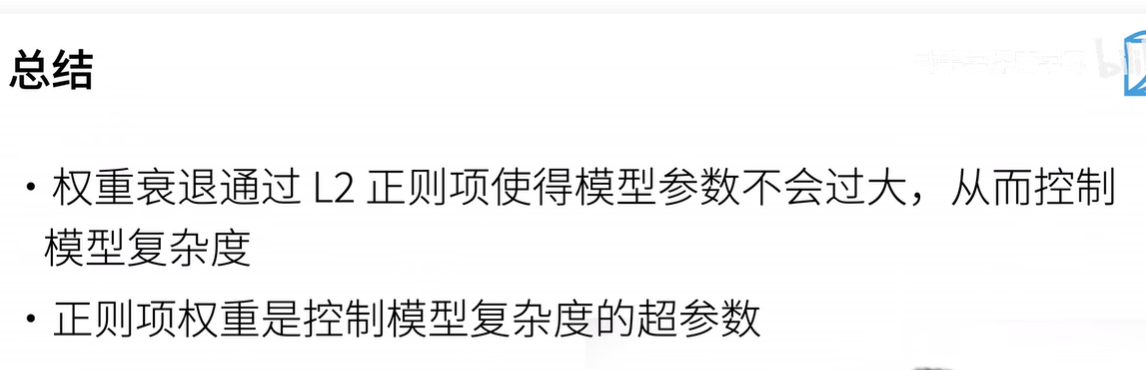

In [1]:
#权重衰退时广泛的使用的正则化的技术之一
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

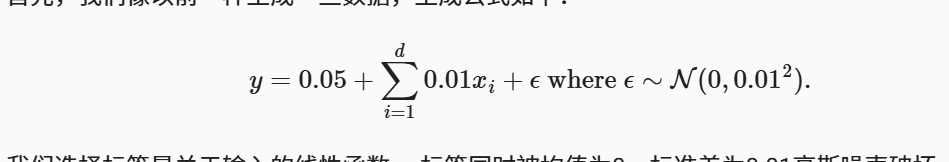

In [6]:
#根据上面的公式 建立数据集

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5

#真实的w和b
true_w = torch.ones((num_inputs, 1)) * 0.01 #0.01是权重
true_b = 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [7]:
#初始化模型

def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [8]:
# 定义L2范数惩罚 
#将权重w 做一次二次计算
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [18]:
# 定义一个训练函数，用于训练带有L2正则化的线性回归模型
def train(lambd):
    w, b = init_params()  # 初始化权重w和偏置b
    
    # 定义线性回归模型和损失函数
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    
    # 设置训练的超参数：训练轮数和学习率
    num_epochs, lr = 200, 0.003
    # 创建一个动画对象，用于绘制训练和测试损失随训练轮数的变化曲线
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    
    # 开始训练模型
    for epoch in range(num_epochs): #每一次数据迭代
        for X, y in train_iter:
            # 计算损失，包括预测误差和L2正则化项
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()  # 反向传播计算梯度
            d2l.sgd([w, b], lr, batch_size)  # 使用随机梯度下降更新参数
        
        # 每训练5轮，记录并绘制一次训练和测试损失
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    
    # 输出最终训练好的权重的L2范数
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 12.251296997070312


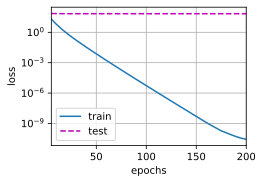

In [19]:
# lambd = 0 来禁用权重衰减 
# 注意，这里训练误差有了减少，但测试误差没有减少， 
# 这意味着出现了严重的过拟合。
train(lambd=0)

w的L2范数是： 0.02423800341784954


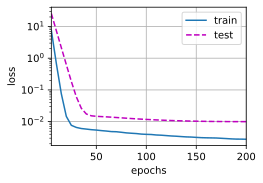

In [21]:
#使用权重衰减来运行代码。 注意，在这里训练误差增大，但测试误差减小。
# 这正是我们期望从正则化中得到的效果。
train(lambd=10)
# ：将 lambd 参数的值设为 3。这个参数用于控制L2正则化项的权重。
# lambda 是正则化参数，w 是模型的权重向量，\|w\|^2 是权重向量的L2范数平方。

In [22]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 15.10423755645752


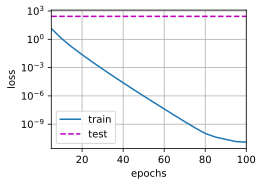

In [23]:
train_concise(0)

w的L2范数： 0.4574970602989197


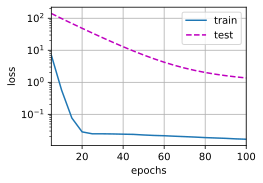

In [24]:
train_concise(3)